# 第17章 基于Transformer的对话实例

## 17.1 数据预处理
1)导入需要的库或模块

In [1]:
import sys
import tensorflow as tf
tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds

import os
import re
import numpy as np
import cv2
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.4.0


初始化GPU\CPU

In [2]:
strategy = tf.distribute.get_strategy()
print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


2）定义一些超参数

In [3]:
# 语言最大长度
MAX_LENGTH = 40

# 最大样本数
MAX_SAMPLES = 50000

# tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

#为Transformer设置的超参数
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 4

3）指定数据存储路径

In [4]:
path_to_dataset = '../data/'
path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

4）预处理函数

In [5]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "that is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence


def load_conversations():
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


questions, answers = load_conversations()

In [6]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: i really , really , really wanna go , but i cannot . not unless my sister goes .
Sample answer: i am working on it . but she does not seem to be going for him .


In [7]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [8]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 271, 3, 271, 3, 141, 384, 173, 3, 40, 4, 612, 2, 11, 865, 30, 2022, 3086, 1]


5）标记化、过滤和填充句子

In [10]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [11]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8278
Number of samples: 44136


6）使用tf.data.Dataset创建数据集。

In [12]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


## 17.2 构建注意力模块
1）构建scaled_dot_product_Attention模块。

scaled_dot_product_Attention模块的核心功能
$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [14]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

 2）构建多头注意力。

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)
  
  def get_config(self):
        config = super(MultiHeadAttention,self).get_config()
        config.update({
            'num_heads':self.num_heads,
            'd_model':self.d_model,
        })
        return config

  def split_heads(self, inputs, batch_size):
    inputs = tf.keras.layers.Lambda(lambda inputs:tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)))(inputs)
    return tf.keras.layers.Lambda(lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3]))(inputs)

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
        scaled_attention, perm=[0, 2, 1, 3]))(scaled_attention)

    # concatenation of heads
    concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model)))(scaled_attention)

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs    

## 17.3 构建Transformer
1）创建掩码。屏蔽批处理中的所有pad标记（值0），以确保模型不会将padding视为输入。

In [16]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [17]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


2）定义前瞻掩码。前瞻掩码用于按顺序屏蔽未来标记符（tokens）。我们还屏蔽了pad令牌

In [18]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [19]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


3）定义位置编码。  
$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [20]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
  
  def get_config(self):

        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,
            
        })
        return config

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

4）可视化位置编码。

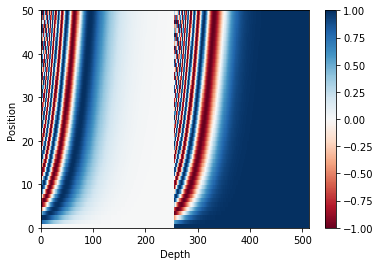

In [21]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

5）构建编码层。

In [22]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  add_attention = tf.keras.layers.add([inputs,attention])
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([attention,outputs])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [23]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


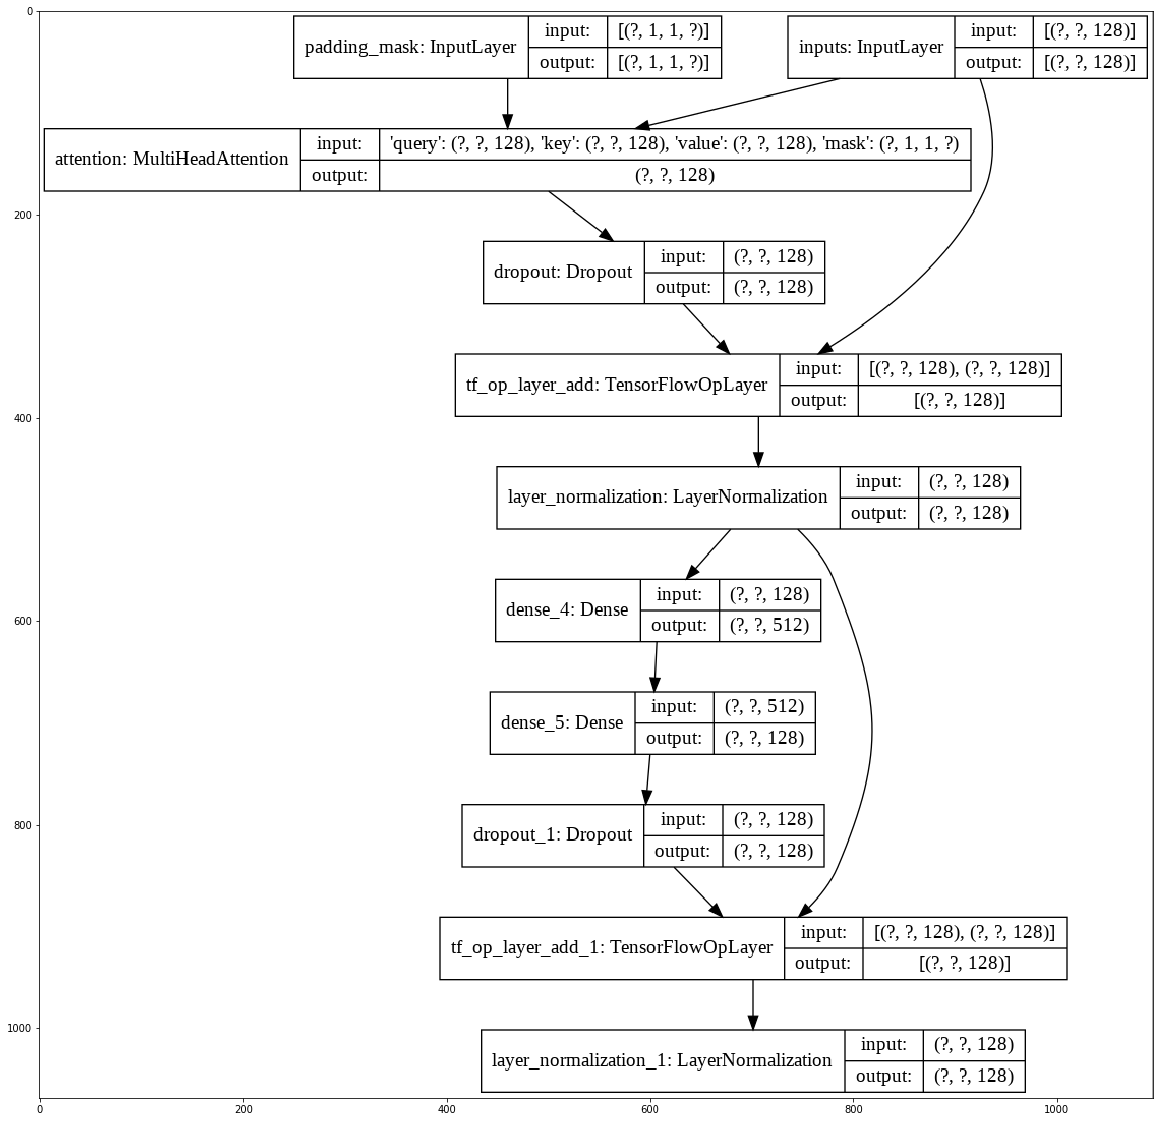

In [24]:
plt.figure(figsize=(30,20))
img = cv2.imread('encoder_layer.png')

#使用plt显示图像
plt.imshow(img)


In [25]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

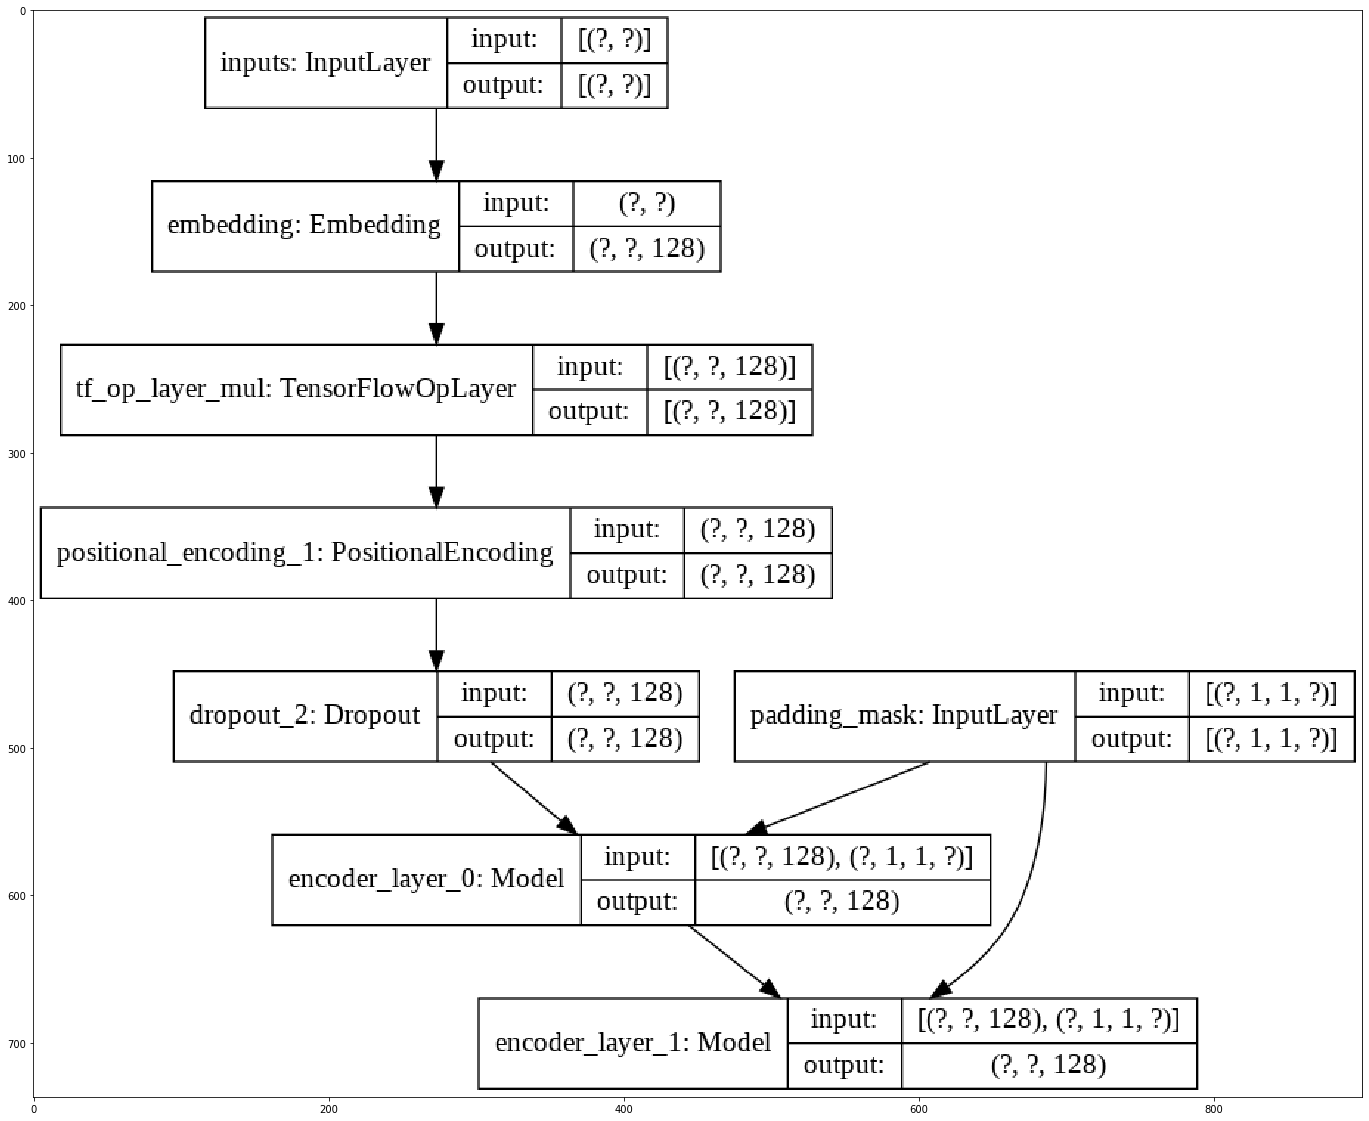

In [26]:
plt.figure(figsize=(30,20))
img = cv2.imread('encoder.png')

#使用plt显示图像
plt.imshow(img)

7）定义解码器层

In [27]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  add_attention = tf.keras.layers.add([attention1,inputs])    
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  add_attention = tf.keras.layers.add([attention2,attention1])
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([outputs,attention2])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

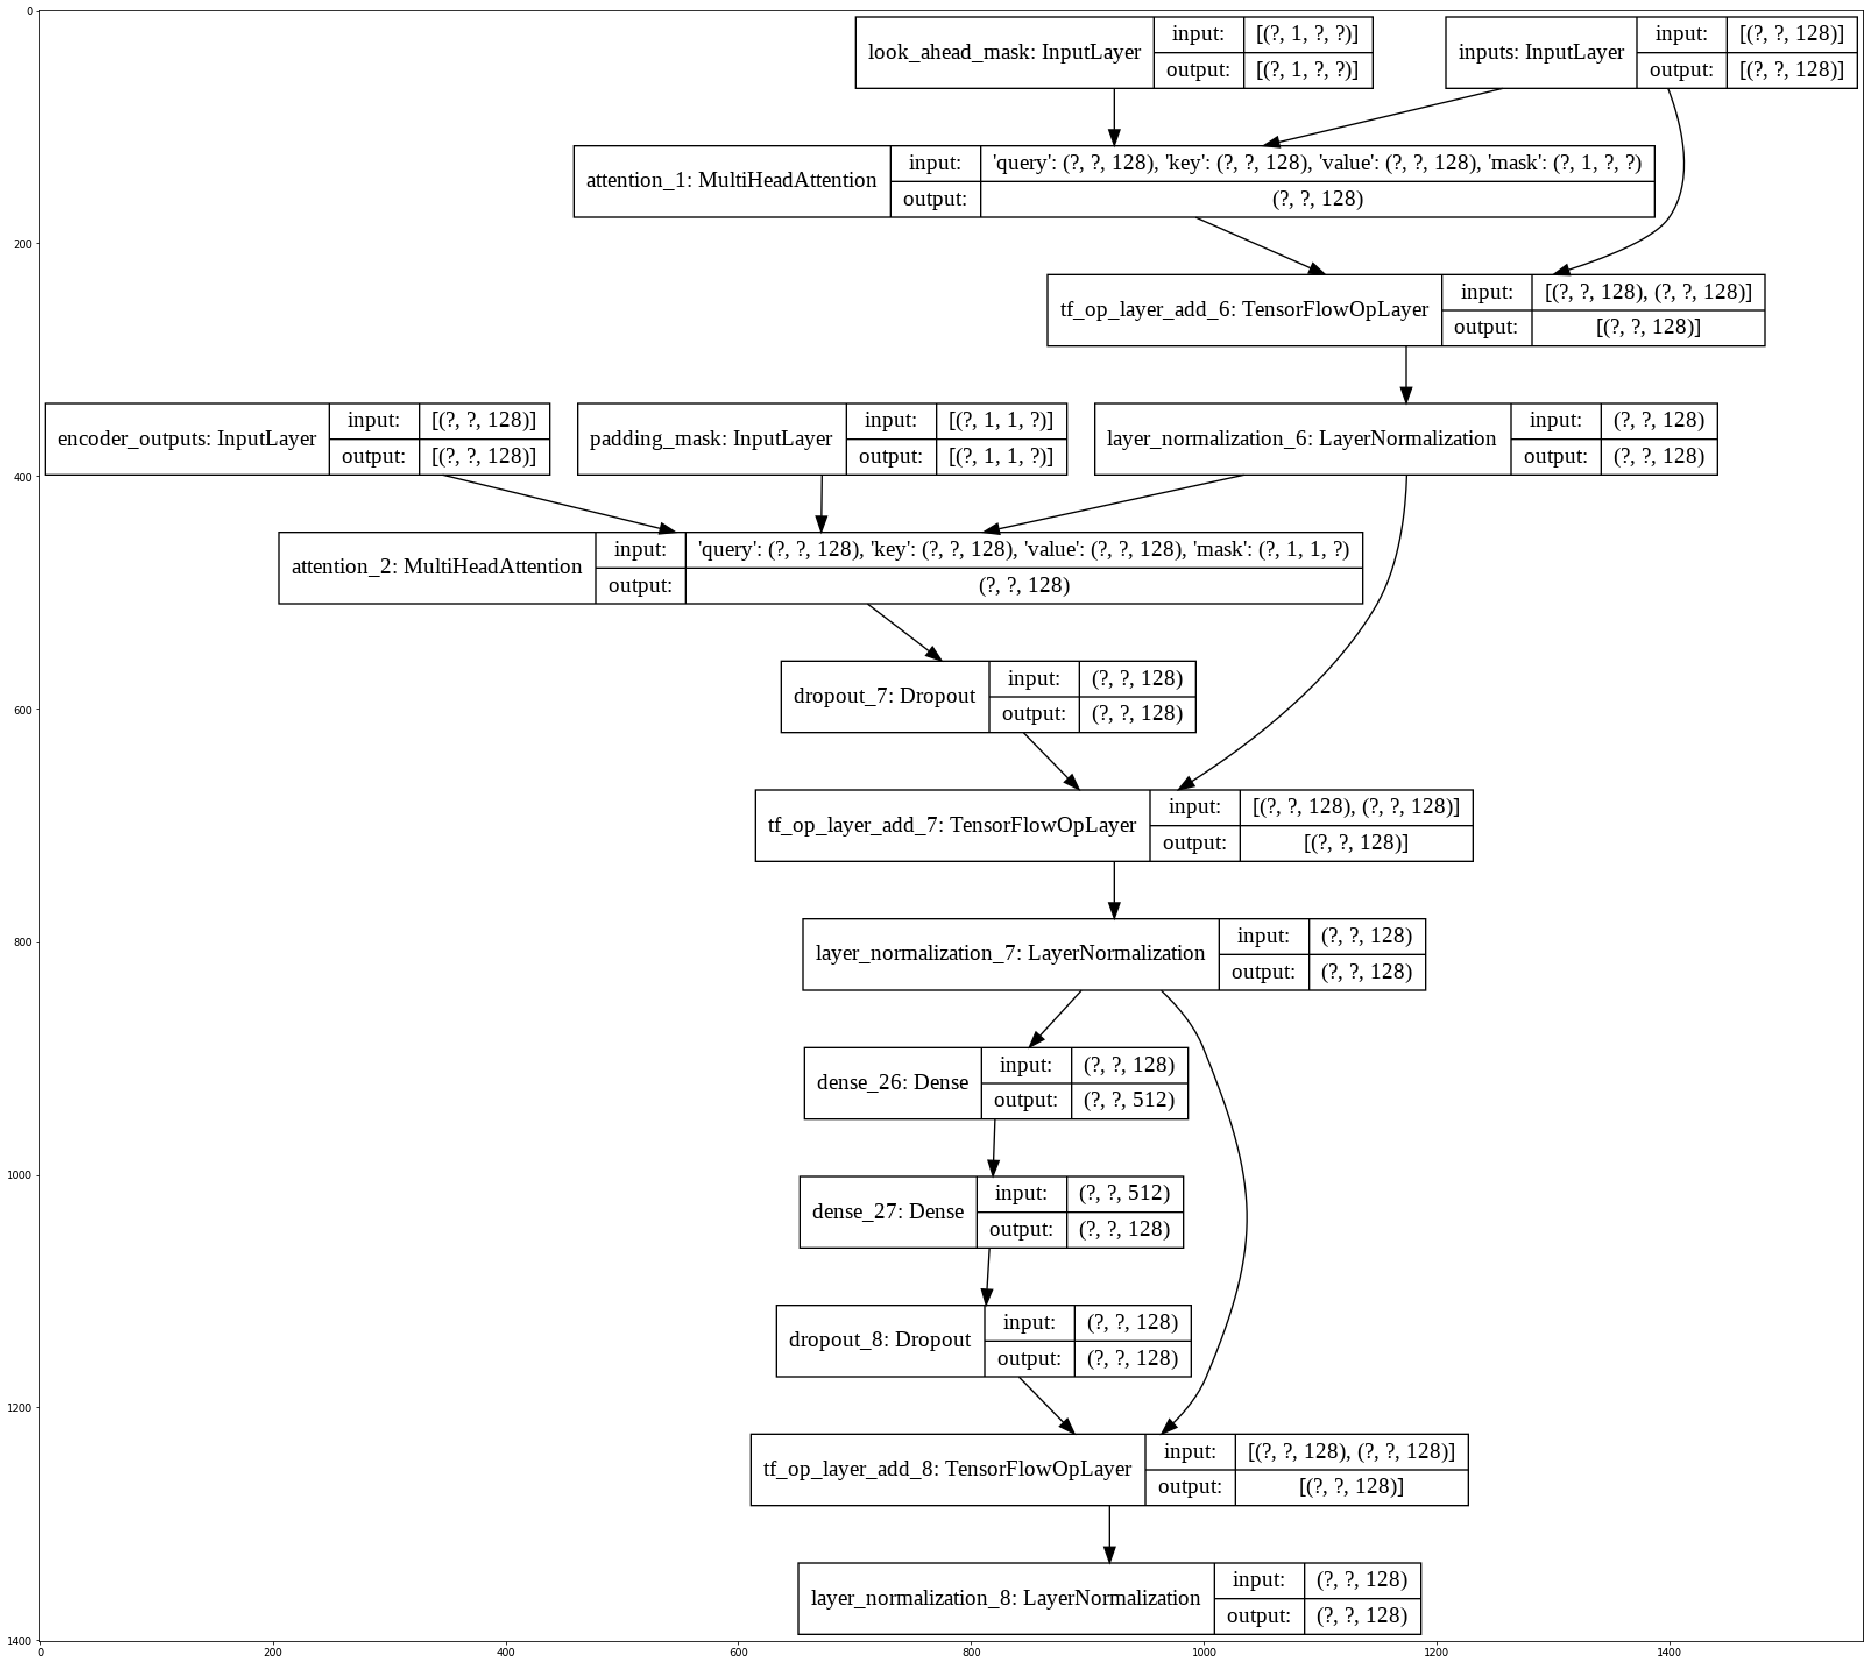

In [28]:
plt.figure(figsize=(40,30))
img = cv2.imread('decoder_layer.png')

#使用plt显示图像
plt.imshow(img)

8）构建解码器

In [29]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

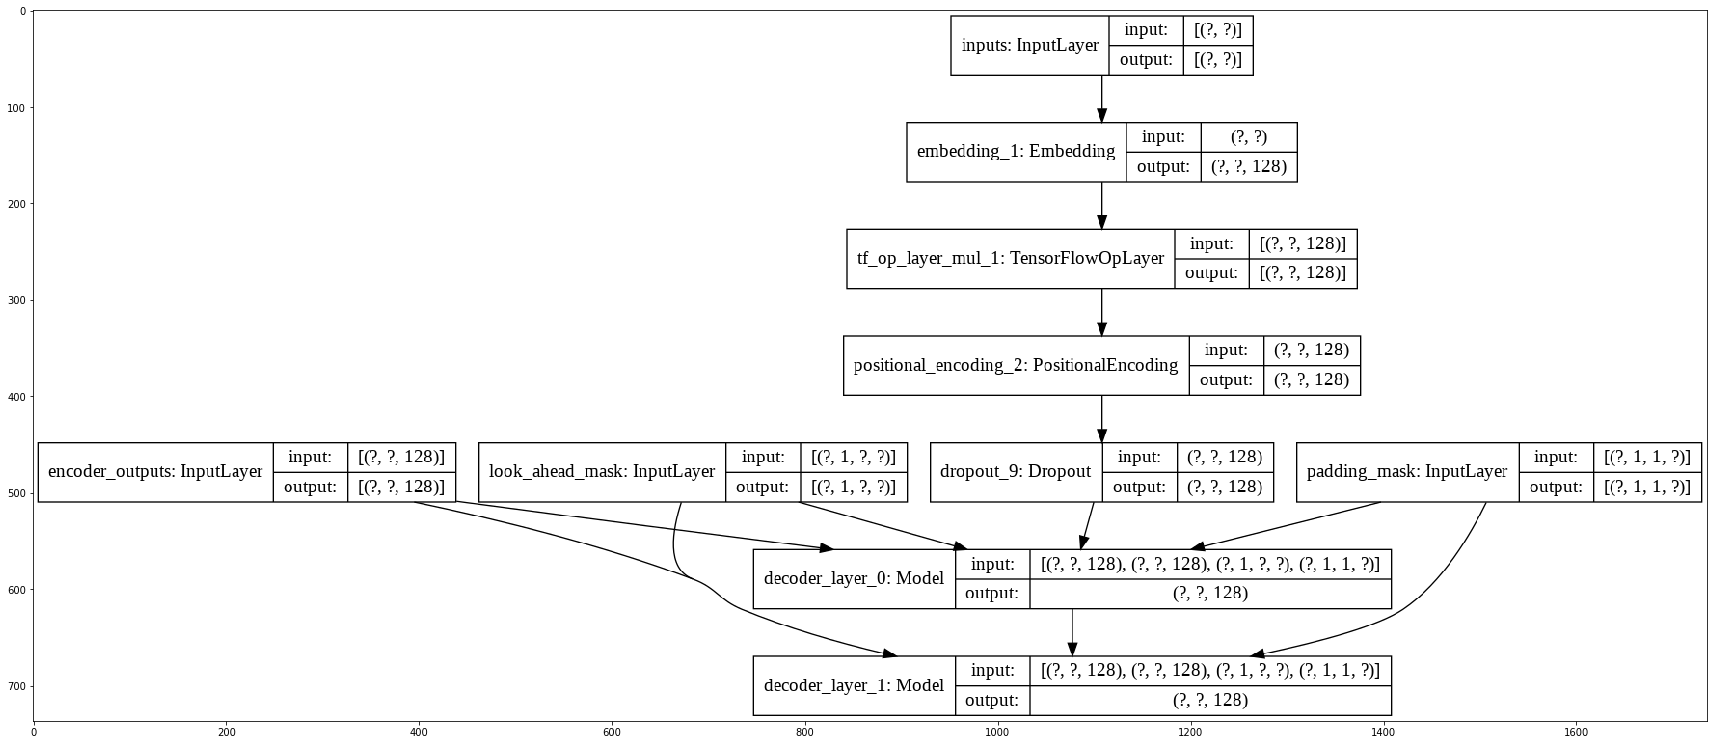

In [30]:
plt.figure(figsize=(30,20))
img = cv2.imread('decoder.png')

#使用plt显示图像
plt.imshow(img)

9）构建transformer模型

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

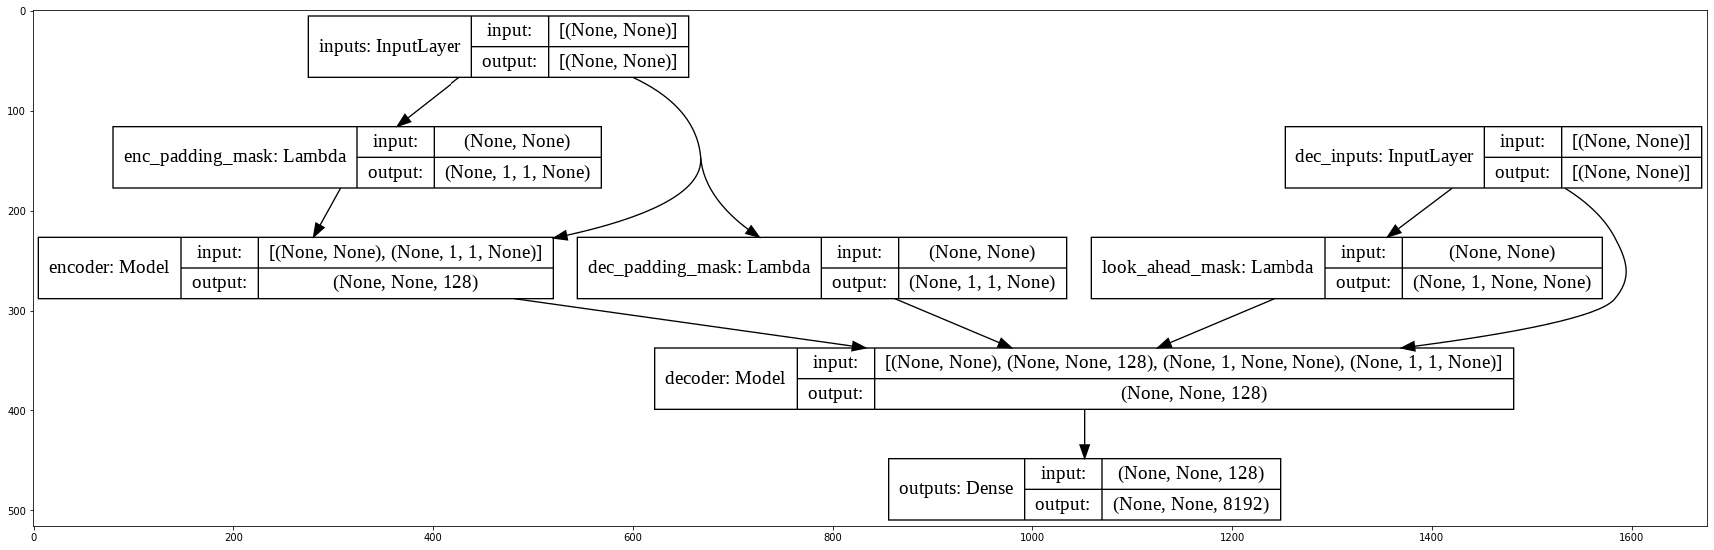

In [32]:
plt.figure(figsize=(30,40))
img = cv2.imread('transformer.png')

#使用plt显示图像
plt.imshow(img)

## 17.4 定义损失函数

In [33]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

动态调整学习率

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = tf.constant(d_model,dtype=tf.float32)
    self.warmup_steps = warmup_steps
    
  def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

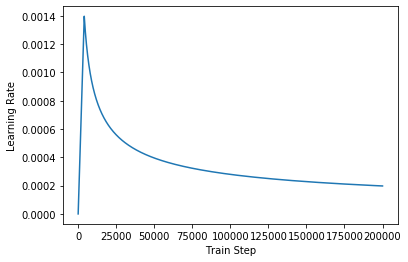

In [35]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 17.5 初始化并编译模型
1）初始化一些变量

In [36]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
with strategy.scope():
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)

  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3173376     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

2）训练模型

In [37]:
model.fit(dataset, epochs=EPOCHS,verbose=1)

Epoch 1/4


180/690 [======>.......................] - ETA: 1:23:35 - loss: 2.9531 - accuracy: 4.0064e-0 - ETA: 1:35 - loss: 2.9626 - accuracy: 3.0048e-04  - ETA: 1:17 - loss: 2.9648 - accuracy: 2.4484e- - ETA: 1:12 - loss: 2.9490 - accuracy: 2.0867e- - ETA: 1:06 - loss: 2.9453 - accuracy: 1.8296e- - ETA: 1:03 - loss: 2.9410 - accuracy: 1.6360e- - ETA: 1:01 - loss: 2.9375 - accuracy: 1.4840e- - ETA: 1:01 - loss: 2.9353 - accuracy: 1.3611e- - ETA: 1:00 - loss: 2.9379 - accuracy: 1.2593e- - ETA: 58s - loss: 2.9410 - accuracy: 1.1735e-04 - ETA: 58s - loss: 2.9414 - accuracy: 1.0999e-0 - ETA: 58s - loss: 2.9419 - accuracy: 1.0361e-0 - ETA: 57s - loss: 2.9403 - accuracy: 9.8007e-0 - ETA: 57s - loss: 2.9380 - accuracy: 9.3051e-0 - ETA: 56s - loss: 2.9359 - accuracy: 8.8628e-0 - ETA: 56s - loss: 2.9324 - accuracy: 8.4654e-0 - ETA: 56s - loss: 2.9283 - accuracy: 8.1060e-0 - ETA: 55s - loss: 2.9250 - accuracy: 7.7794e-0 - ETA: 55s - loss: 2.9215 - accuracy: 7.4809e-0 - ETA: 55s - loss: 2.9177 - accuracy: 7

366/690 [==============>...............] - ETA: 40s - loss: 2.8582 - accuracy: 0.010 - ETA: 40s - loss: 2.8577 - accuracy: 0.010 - ETA: 40s - loss: 2.8572 - accuracy: 0.010 - ETA: 40s - loss: 2.8567 - accuracy: 0.010 - ETA: 40s - loss: 2.8561 - accuracy: 0.010 - ETA: 40s - loss: 2.8556 - accuracy: 0.010 - ETA: 40s - loss: 2.8551 - accuracy: 0.010 - ETA: 40s - loss: 2.8546 - accuracy: 0.010 - ETA: 40s - loss: 2.8541 - accuracy: 0.010 - ETA: 40s - loss: 2.8536 - accuracy: 0.010 - ETA: 40s - loss: 2.8531 - accuracy: 0.010 - ETA: 39s - loss: 2.8526 - accuracy: 0.010 - ETA: 39s - loss: 2.8520 - accuracy: 0.010 - ETA: 39s - loss: 2.8515 - accuracy: 0.011 - ETA: 39s - loss: 2.8510 - accuracy: 0.011 - ETA: 39s - loss: 2.8504 - accuracy: 0.011 - ETA: 39s - loss: 2.8499 - accuracy: 0.011 - ETA: 39s - loss: 2.8493 - accuracy: 0.011 - ETA: 39s - loss: 2.8487 - accuracy: 0.011 - ETA: 39s - loss: 2.8482 - accuracy: 0.011 - ETA: 39s - loss: 2.8476 - accuracy: 0.011 - ETA: 39s - loss: 2.8471 - accurac

552/690 [=======================>......] - ETA: 25s - loss: 2.7303 - accuracy: 0.016 - ETA: 25s - loss: 2.7295 - accuracy: 0.016 - ETA: 25s - loss: 2.7287 - accuracy: 0.016 - ETA: 25s - loss: 2.7280 - accuracy: 0.016 - ETA: 25s - loss: 2.7272 - accuracy: 0.016 - ETA: 25s - loss: 2.7264 - accuracy: 0.016 - ETA: 25s - loss: 2.7257 - accuracy: 0.016 - ETA: 25s - loss: 2.7249 - accuracy: 0.016 - ETA: 25s - loss: 2.7241 - accuracy: 0.016 - ETA: 25s - loss: 2.7233 - accuracy: 0.016 - ETA: 25s - loss: 2.7226 - accuracy: 0.016 - ETA: 25s - loss: 2.7218 - accuracy: 0.016 - ETA: 24s - loss: 2.7210 - accuracy: 0.016 - ETA: 24s - loss: 2.7203 - accuracy: 0.016 - ETA: 24s - loss: 2.7195 - accuracy: 0.016 - ETA: 24s - loss: 2.7187 - accuracy: 0.016 - ETA: 24s - loss: 2.7179 - accuracy: 0.016 - ETA: 24s - loss: 2.7172 - accuracy: 0.016 - ETA: 24s - loss: 2.7164 - accuracy: 0.016 - ETA: 24s - loss: 2.7156 - accuracy: 0.016 - ETA: 24s - loss: 2.7148 - accuracy: 0.016 - ETA: 24s - loss: 2.7141 - accurac

690/690 [==============================] - ETA: 10s - loss: 2.5951 - accuracy: 0.020 - ETA: 10s - loss: 2.5944 - accuracy: 0.020 - ETA: 10s - loss: 2.5938 - accuracy: 0.021 - ETA: 10s - loss: 2.5931 - accuracy: 0.021 - ETA: 10s - loss: 2.5924 - accuracy: 0.021 - ETA: 10s - loss: 2.5918 - accuracy: 0.021 - ETA: 10s - loss: 2.5911 - accuracy: 0.021 - ETA: 10s - loss: 2.5904 - accuracy: 0.021 - ETA: 10s - loss: 2.5898 - accuracy: 0.021 - ETA: 10s - loss: 2.5891 - accuracy: 0.021 - ETA: 10s - loss: 2.5884 - accuracy: 0.021 - ETA: 10s - loss: 2.5878 - accuracy: 0.021 - ETA: 10s - loss: 2.5871 - accuracy: 0.021 - ETA: 9s - loss: 2.5865 - accuracy: 0.021 - ETA: 9s - loss: 2.5858 - accuracy: 0.02 - ETA: 9s - loss: 2.5851 - accuracy: 0.02 - ETA: 9s - loss: 2.5845 - accuracy: 0.02 - ETA: 9s - loss: 2.5838 - accuracy: 0.02 - ETA: 9s - loss: 2.5832 - accuracy: 0.02 - ETA: 9s - loss: 2.5825 - accuracy: 0.02 - ETA: 9s - loss: 2.5818 - accuracy: 0.02 - ETA: 9s - loss: 2.5812 - accuracy: 0.02 - ETA: 9

186/690 [=======>......................] - ETA: 54s - loss: 1.3888 - accuracy: 0.063 - ETA: 51s - loss: 1.5326 - accuracy: 0.065 - ETA: 52s - loss: 1.5880 - accuracy: 0.066 - ETA: 54s - loss: 1.6182 - accuracy: 0.067 - ETA: 54s - loss: 1.6305 - accuracy: 0.067 - ETA: 53s - loss: 1.6286 - accuracy: 0.068 - ETA: 55s - loss: 1.6287 - accuracy: 0.068 - ETA: 55s - loss: 1.6298 - accuracy: 0.068 - ETA: 55s - loss: 1.6294 - accuracy: 0.068 - ETA: 55s - loss: 1.6275 - accuracy: 0.068 - ETA: 54s - loss: 1.6258 - accuracy: 0.069 - ETA: 54s - loss: 1.6223 - accuracy: 0.069 - ETA: 54s - loss: 1.6170 - accuracy: 0.069 - ETA: 54s - loss: 1.6128 - accuracy: 0.069 - ETA: 54s - loss: 1.6100 - accuracy: 0.069 - ETA: 54s - loss: 1.6080 - accuracy: 0.069 - ETA: 53s - loss: 1.6059 - accuracy: 0.069 - ETA: 53s - loss: 1.6041 - accuracy: 0.069 - ETA: 53s - loss: 1.6028 - accuracy: 0.069 - ETA: 53s - loss: 1.6014 - accuracy: 0.069 - ETA: 53s - loss: 1.5996 - accuracy: 0.069 - ETA: 53s - loss: 1.5976 - accurac

372/690 [===============>..............] - ETA: 40s - loss: 1.5850 - accuracy: 0.072 - ETA: 40s - loss: 1.5849 - accuracy: 0.072 - ETA: 40s - loss: 1.5848 - accuracy: 0.072 - ETA: 40s - loss: 1.5847 - accuracy: 0.072 - ETA: 40s - loss: 1.5846 - accuracy: 0.072 - ETA: 39s - loss: 1.5845 - accuracy: 0.072 - ETA: 39s - loss: 1.5844 - accuracy: 0.072 - ETA: 39s - loss: 1.5843 - accuracy: 0.072 - ETA: 39s - loss: 1.5842 - accuracy: 0.072 - ETA: 39s - loss: 1.5842 - accuracy: 0.072 - ETA: 39s - loss: 1.5841 - accuracy: 0.072 - ETA: 39s - loss: 1.5840 - accuracy: 0.072 - ETA: 39s - loss: 1.5839 - accuracy: 0.072 - ETA: 39s - loss: 1.5838 - accuracy: 0.072 - ETA: 39s - loss: 1.5837 - accuracy: 0.072 - ETA: 39s - loss: 1.5836 - accuracy: 0.072 - ETA: 39s - loss: 1.5835 - accuracy: 0.072 - ETA: 39s - loss: 1.5834 - accuracy: 0.072 - ETA: 38s - loss: 1.5833 - accuracy: 0.072 - ETA: 38s - loss: 1.5832 - accuracy: 0.072 - ETA: 38s - loss: 1.5831 - accuracy: 0.072 - ETA: 38s - loss: 1.5830 - accurac

558/690 [=======================>......] - ETA: 25s - loss: 1.5665 - accuracy: 0.073 - ETA: 25s - loss: 1.5664 - accuracy: 0.073 - ETA: 25s - loss: 1.5663 - accuracy: 0.073 - ETA: 25s - loss: 1.5662 - accuracy: 0.073 - ETA: 25s - loss: 1.5661 - accuracy: 0.073 - ETA: 25s - loss: 1.5660 - accuracy: 0.073 - ETA: 24s - loss: 1.5659 - accuracy: 0.073 - ETA: 24s - loss: 1.5658 - accuracy: 0.073 - ETA: 24s - loss: 1.5657 - accuracy: 0.073 - ETA: 24s - loss: 1.5656 - accuracy: 0.073 - ETA: 24s - loss: 1.5655 - accuracy: 0.073 - ETA: 24s - loss: 1.5654 - accuracy: 0.073 - ETA: 24s - loss: 1.5653 - accuracy: 0.073 - ETA: 24s - loss: 1.5652 - accuracy: 0.073 - ETA: 24s - loss: 1.5651 - accuracy: 0.073 - ETA: 24s - loss: 1.5650 - accuracy: 0.073 - ETA: 24s - loss: 1.5649 - accuracy: 0.073 - ETA: 24s - loss: 1.5648 - accuracy: 0.073 - ETA: 23s - loss: 1.5647 - accuracy: 0.073 - ETA: 23s - loss: 1.5646 - accuracy: 0.073 - ETA: 23s - loss: 1.5645 - accuracy: 0.073 - ETA: 23s - loss: 1.5645 - accurac

690/690 [==============================] - ETA: 10s - loss: 1.5507 - accuracy: 0.074 - ETA: 10s - loss: 1.5507 - accuracy: 0.074 - ETA: 10s - loss: 1.5506 - accuracy: 0.074 - ETA: 10s - loss: 1.5505 - accuracy: 0.074 - ETA: 10s - loss: 1.5504 - accuracy: 0.074 - ETA: 10s - loss: 1.5503 - accuracy: 0.074 - ETA: 10s - loss: 1.5503 - accuracy: 0.074 - ETA: 9s - loss: 1.5502 - accuracy: 0.074 - ETA: 9s - loss: 1.5501 - accuracy: 0.07 - ETA: 9s - loss: 1.5500 - accuracy: 0.07 - ETA: 9s - loss: 1.5500 - accuracy: 0.07 - ETA: 9s - loss: 1.5499 - accuracy: 0.07 - ETA: 9s - loss: 1.5498 - accuracy: 0.07 - ETA: 9s - loss: 1.5497 - accuracy: 0.07 - ETA: 9s - loss: 1.5496 - accuracy: 0.07 - ETA: 9s - loss: 1.5496 - accuracy: 0.07 - ETA: 9s - loss: 1.5495 - accuracy: 0.07 - ETA: 9s - loss: 1.5494 - accuracy: 0.07 - ETA: 9s - loss: 1.5493 - accuracy: 0.07 - ETA: 8s - loss: 1.5493 - accuracy: 0.07 - ETA: 8s - loss: 1.5492 - accuracy: 0.07 - ETA: 8s - loss: 1.5491 - accuracy: 0.07 - ETA: 8s - loss: 1.

186/690 [=======>......................] - ETA: 50s - loss: 1.6487 - accuracy: 0.084 - ETA: 1:00 - loss: 1.6138 - accuracy: 0.08 - ETA: 53s - loss: 1.5907 - accuracy: 0.0858 - ETA: 54s - loss: 1.5821 - accuracy: 0.086 - ETA: 54s - loss: 1.5711 - accuracy: 0.086 - ETA: 56s - loss: 1.5642 - accuracy: 0.086 - ETA: 54s - loss: 1.5538 - accuracy: 0.086 - ETA: 55s - loss: 1.5451 - accuracy: 0.086 - ETA: 55s - loss: 1.5389 - accuracy: 0.086 - ETA: 54s - loss: 1.5320 - accuracy: 0.086 - ETA: 54s - loss: 1.5269 - accuracy: 0.086 - ETA: 54s - loss: 1.5219 - accuracy: 0.086 - ETA: 54s - loss: 1.5181 - accuracy: 0.086 - ETA: 54s - loss: 1.5159 - accuracy: 0.086 - ETA: 54s - loss: 1.5137 - accuracy: 0.086 - ETA: 54s - loss: 1.5120 - accuracy: 0.086 - ETA: 54s - loss: 1.5097 - accuracy: 0.086 - ETA: 54s - loss: 1.5081 - accuracy: 0.086 - ETA: 54s - loss: 1.5070 - accuracy: 0.086 - ETA: 54s - loss: 1.5050 - accuracy: 0.085 - ETA: 54s - loss: 1.5029 - accuracy: 0.085 - ETA: 54s - loss: 1.5008 - accura

372/690 [===============>..............] - ETA: 40s - loss: 1.4470 - accuracy: 0.083 - ETA: 40s - loss: 1.4468 - accuracy: 0.083 - ETA: 40s - loss: 1.4466 - accuracy: 0.083 - ETA: 40s - loss: 1.4465 - accuracy: 0.083 - ETA: 40s - loss: 1.4463 - accuracy: 0.083 - ETA: 39s - loss: 1.4461 - accuracy: 0.083 - ETA: 39s - loss: 1.4460 - accuracy: 0.083 - ETA: 39s - loss: 1.4458 - accuracy: 0.083 - ETA: 39s - loss: 1.4456 - accuracy: 0.083 - ETA: 39s - loss: 1.4455 - accuracy: 0.083 - ETA: 39s - loss: 1.4453 - accuracy: 0.083 - ETA: 39s - loss: 1.4451 - accuracy: 0.083 - ETA: 39s - loss: 1.4449 - accuracy: 0.083 - ETA: 39s - loss: 1.4448 - accuracy: 0.083 - ETA: 39s - loss: 1.4446 - accuracy: 0.083 - ETA: 39s - loss: 1.4444 - accuracy: 0.083 - ETA: 39s - loss: 1.4443 - accuracy: 0.083 - ETA: 38s - loss: 1.4441 - accuracy: 0.083 - ETA: 38s - loss: 1.4439 - accuracy: 0.083 - ETA: 38s - loss: 1.4437 - accuracy: 0.083 - ETA: 38s - loss: 1.4436 - accuracy: 0.083 - ETA: 38s - loss: 1.4434 - accurac

558/690 [=======================>......] - ETA: 25s - loss: 1.4260 - accuracy: 0.083 - ETA: 25s - loss: 1.4260 - accuracy: 0.083 - ETA: 25s - loss: 1.4259 - accuracy: 0.083 - ETA: 25s - loss: 1.4258 - accuracy: 0.083 - ETA: 25s - loss: 1.4258 - accuracy: 0.083 - ETA: 25s - loss: 1.4257 - accuracy: 0.083 - ETA: 24s - loss: 1.4256 - accuracy: 0.083 - ETA: 24s - loss: 1.4256 - accuracy: 0.083 - ETA: 24s - loss: 1.4255 - accuracy: 0.083 - ETA: 24s - loss: 1.4255 - accuracy: 0.083 - ETA: 24s - loss: 1.4254 - accuracy: 0.083 - ETA: 24s - loss: 1.4253 - accuracy: 0.083 - ETA: 24s - loss: 1.4253 - accuracy: 0.083 - ETA: 24s - loss: 1.4252 - accuracy: 0.083 - ETA: 24s - loss: 1.4252 - accuracy: 0.083 - ETA: 24s - loss: 1.4251 - accuracy: 0.083 - ETA: 24s - loss: 1.4250 - accuracy: 0.083 - ETA: 24s - loss: 1.4250 - accuracy: 0.083 - ETA: 23s - loss: 1.4249 - accuracy: 0.083 - ETA: 23s - loss: 1.4249 - accuracy: 0.083 - ETA: 23s - loss: 1.4248 - accuracy: 0.083 - ETA: 23s - loss: 1.4247 - accurac

690/690 [==============================] - ETA: 10s - loss: 1.4171 - accuracy: 0.083 - ETA: 10s - loss: 1.4170 - accuracy: 0.083 - ETA: 10s - loss: 1.4170 - accuracy: 0.083 - ETA: 10s - loss: 1.4169 - accuracy: 0.083 - ETA: 10s - loss: 1.4169 - accuracy: 0.083 - ETA: 10s - loss: 1.4169 - accuracy: 0.083 - ETA: 10s - loss: 1.4168 - accuracy: 0.083 - ETA: 9s - loss: 1.4168 - accuracy: 0.083 - ETA: 9s - loss: 1.4167 - accuracy: 0.08 - ETA: 9s - loss: 1.4167 - accuracy: 0.08 - ETA: 9s - loss: 1.4167 - accuracy: 0.08 - ETA: 9s - loss: 1.4166 - accuracy: 0.08 - ETA: 9s - loss: 1.4166 - accuracy: 0.08 - ETA: 9s - loss: 1.4165 - accuracy: 0.08 - ETA: 9s - loss: 1.4165 - accuracy: 0.08 - ETA: 9s - loss: 1.4164 - accuracy: 0.08 - ETA: 9s - loss: 1.4164 - accuracy: 0.08 - ETA: 9s - loss: 1.4164 - accuracy: 0.08 - ETA: 9s - loss: 1.4163 - accuracy: 0.08 - ETA: 8s - loss: 1.4163 - accuracy: 0.08 - ETA: 8s - loss: 1.4162 - accuracy: 0.08 - ETA: 8s - loss: 1.4162 - accuracy: 0.08 - ETA: 8s - loss: 1.

186/690 [=======>......................] - ETA: 57s - loss: 1.4508 - accuracy: 0.104 - ETA: 1:02 - loss: 1.4838 - accuracy: 0.10 - ETA: 54s - loss: 1.4643 - accuracy: 0.0984 - ETA: 56s - loss: 1.4494 - accuracy: 0.096 - ETA: 56s - loss: 1.4405 - accuracy: 0.096 - ETA: 56s - loss: 1.4330 - accuracy: 0.095 - ETA: 56s - loss: 1.4256 - accuracy: 0.094 - ETA: 54s - loss: 1.4208 - accuracy: 0.094 - ETA: 55s - loss: 1.4166 - accuracy: 0.094 - ETA: 55s - loss: 1.4139 - accuracy: 0.093 - ETA: 54s - loss: 1.4112 - accuracy: 0.093 - ETA: 55s - loss: 1.4090 - accuracy: 0.093 - ETA: 54s - loss: 1.4066 - accuracy: 0.092 - ETA: 55s - loss: 1.4035 - accuracy: 0.092 - ETA: 54s - loss: 1.4007 - accuracy: 0.092 - ETA: 54s - loss: 1.3979 - accuracy: 0.091 - ETA: 54s - loss: 1.3950 - accuracy: 0.091 - ETA: 54s - loss: 1.3922 - accuracy: 0.091 - ETA: 54s - loss: 1.3896 - accuracy: 0.091 - ETA: 54s - loss: 1.3873 - accuracy: 0.091 - ETA: 53s - loss: 1.3849 - accuracy: 0.091 - ETA: 53s - loss: 1.3825 - accura

372/690 [===============>..............] - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 40s - loss: 1.3423 - accuracy: 0.088 - ETA: 39s - loss: 1.3423 - accuracy: 0.088 - ETA: 39s - loss: 1.3423 - accuracy: 0.088 - ETA: 39s - loss: 1.3423 - accuracy: 0.088 - ETA: 39s - loss: 1.3423 - accuracy: 0.088 - ETA: 39s - loss: 1.3423 - accuracy: 0.088 - ETA: 39s - loss: 1.3424 - accuracy: 0.088 - ETA: 39s - loss: 1.3424 - accuracy: 0.088 - ETA: 39s - loss: 1.3424 - accuracy: 0.088 - ETA: 39s - loss: 1.3424 - accuracy: 0.088 - ETA: 39s - loss: 1.3424 - accuracy: 0.088 - ETA: 39s - loss: 1.3424 - accuracy: 0.088 - ETA: 39s - loss: 1.3424 - accurac

558/690 [=======================>......] - ETA: 25s - loss: 1.3418 - accuracy: 0.088 - ETA: 25s - loss: 1.3418 - accuracy: 0.088 - ETA: 25s - loss: 1.3418 - accuracy: 0.088 - ETA: 25s - loss: 1.3418 - accuracy: 0.088 - ETA: 25s - loss: 1.3418 - accuracy: 0.088 - ETA: 25s - loss: 1.3418 - accuracy: 0.088 - ETA: 25s - loss: 1.3418 - accuracy: 0.088 - ETA: 25s - loss: 1.3417 - accuracy: 0.088 - ETA: 25s - loss: 1.3417 - accuracy: 0.088 - ETA: 24s - loss: 1.3417 - accuracy: 0.088 - ETA: 24s - loss: 1.3417 - accuracy: 0.088 - ETA: 24s - loss: 1.3417 - accuracy: 0.088 - ETA: 24s - loss: 1.3417 - accuracy: 0.088 - ETA: 24s - loss: 1.3417 - accuracy: 0.088 - ETA: 24s - loss: 1.3417 - accuracy: 0.088 - ETA: 24s - loss: 1.3417 - accuracy: 0.088 - ETA: 24s - loss: 1.3416 - accuracy: 0.088 - ETA: 24s - loss: 1.3416 - accuracy: 0.088 - ETA: 24s - loss: 1.3416 - accuracy: 0.088 - ETA: 24s - loss: 1.3416 - accuracy: 0.088 - ETA: 24s - loss: 1.3416 - accuracy: 0.088 - ETA: 23s - loss: 1.3416 - accurac

690/690 [==============================] - ETA: 10s - loss: 1.3403 - accuracy: 0.088 - ETA: 10s - loss: 1.3403 - accuracy: 0.088 - ETA: 10s - loss: 1.3403 - accuracy: 0.088 - ETA: 10s - loss: 1.3403 - accuracy: 0.088 - ETA: 10s - loss: 1.3403 - accuracy: 0.088 - ETA: 10s - loss: 1.3403 - accuracy: 0.088 - ETA: 10s - loss: 1.3403 - accuracy: 0.088 - ETA: 10s - loss: 1.3403 - accuracy: 0.088 - ETA: 9s - loss: 1.3402 - accuracy: 0.088 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 9s - loss: 1.3402 - accuracy: 0.08 - ETA: 8s - loss: 1.3402 - accuracy: 0.08 - ETA: 8s - loss: 

## 17.6 测试评估模型

In [38]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [39]:
output = predict('Where have you been?')

Input: Where have you been?
Output: i do not know . i am not going to get out of here .


In [40]:
output = predict("It's a trap")

Input: It's a trap
Output: i do not know what i am going to do with you .


In [41]:
# feed the model with its previous output
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
  sentence = predict(sentence)
  print('')

Input: I am not crazy, my mother had me tested.
Output: i do not know what i am going to do with you .

Input: i do not know what i am going to do with you .
Output: i do not know what i am going to do with you .

Input: i do not know what i am going to do with you .
Output: i do not know what i am going to do with you .

Input: i do not know what i am going to do with you .
Output: i do not know what i am going to do with you .

Input: i do not know what i am going to do with you .
Output: i do not know what i am going to do with you .



从结果来看，效果非常不错！